In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:

# Attribute Information:

data_info = pd.read_csv("/content/drive/My Drive/Project/Project/NUSW-NB15_features.csv", encoding = "ISO-8859-1")

In [0]:

# Retrieve Attribute Names

column_attributes = list (data_info['Name'])

In [0]:
# Read the data available in 4 csv files using temporary data frames

dataframe1 = pd.read_csv("/content/drive/My Drive/Project/Project/UNSW-NB15_1.csv",low_memory=False, header=None)
dataframe2 = pd.read_csv("/content/drive/My Drive/Project/Project/UNSW-NB15_2.csv", low_memory=False, header=None)
dataframe3 = pd.read_csv("/content/drive/My Drive/Project/Project/UNSW-NB15_3.csv", low_memory=False, header=None)
dataframe4 = pd.read_csv("/content/drive/My Drive/Project/Project/UNSW-NB15_4.csv",low_memory=False, header=None)

In [0]:
# Name the columns of all data frames using attribute names from features.csv

df_list = [dataframe1,dataframe2,dataframe3,dataframe4]
for df in df_list:
    name = [v.lower() for k, v in enumerate(column_attributes)]
    df.columns = name

In [6]:
# Concatenate the 4 temporary data frames into one single data frame

dataset = pd.concat([dataframe1, dataframe2, dataframe3, dataframe4])
dataset.shape

(2540047, 49)

In [0]:

# Delete temporary data frames

del dataframe1
del dataframe2
del dataframe3
del dataframe4

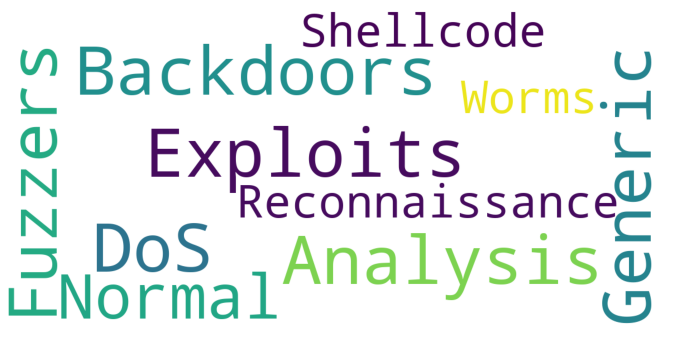

In [8]:
# Function to show the different attack cateegories present in the dataset

stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):

    attack_catgs = data.loc[:,'attack_cat'].replace('Backdoor','Backdoors', regex=False)
    attack_catgs = attack_catgs.dropna().to_numpy()
    attack_catgs = [x.strip(' ') for x in attack_catgs]
    attack_catgs = np.unique(attack_catgs)
    text = " ".join(str(item) for item in attack_catgs)
    wordcloud = WordCloud(
        background_color='white',
        collocations=False,
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(text)
 
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(dataset)

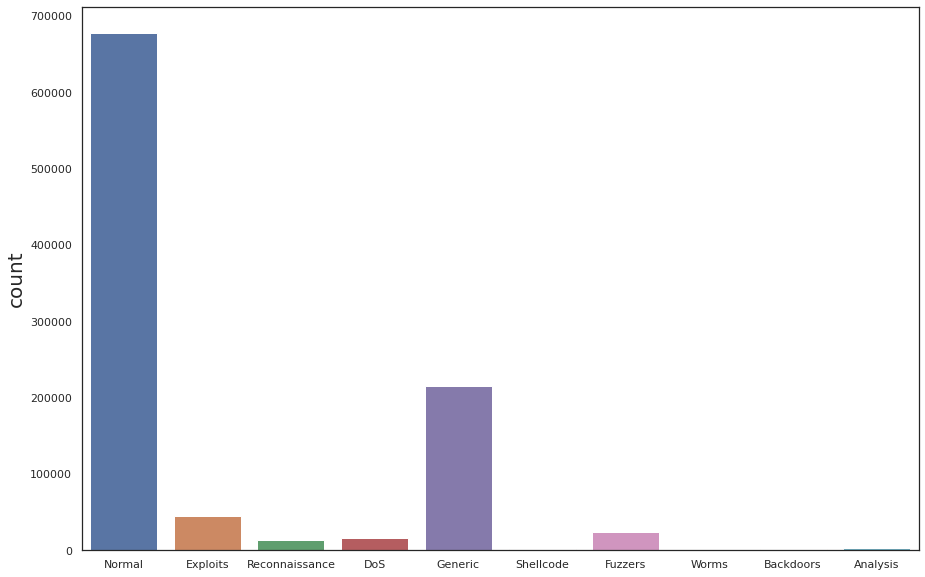

In [9]:
# Plot to show the distribution of all attack categories

def plot_attack_category(data):
    attack_catgs = data.loc[:,'attack_cat'].replace('Backdoor','Backdoors', regex=False)
    attack_catgs = attack_catgs.dropna().to_numpy()
    attack_catgs = [x.strip(' ') for x in attack_catgs]
    sns.set(rc={'figure.figsize':(15,10),"font.size":70,"axes.titlesize":40,"axes.labelsize":20},style="white")
    catg_plot = sns.countplot(attack_catgs,data = data)
    
plot_attack_category(dataset)

In [10]:
# Provided data is not consistent. Check and make relevant changes

columns_with_space = dataset.columns[dataset.isin([' ']).any()].tolist()
print('columns_with_space ',columns_with_space)
columns_with_null = dataset.columns[dataset.isna().any()].tolist()
print('columns_with_null ', columns_with_null)
columns_with_dash = dataset.columns[dataset.isin(['-']).any()].tolist()
print('columns_with_dash', columns_with_dash)

columns_with_space  ['ct_ftp_cmd']
columns_with_null  ['ct_flw_http_mthd', 'is_ftp_login', 'attack_cat']
columns_with_dash ['sport', 'dsport', 'service']


In [0]:

# Handle null and '-' values

# Where attack_cat not mentioned, replace with 'Normal'
dataset.loc[:,'attack_cat'] = dataset.loc[:,'attack_cat'].replace(np.nan,'Normal', regex=True)

dataset.loc[:,'ct_flw_http_mthd'] = dataset.loc[:,'ct_flw_http_mthd'].replace(np.nan,0, regex=True)
dataset.loc[:,'is_ftp_login'] = dataset.loc[:,'is_ftp_login'].replace(np.nan,0, regex=True)

dataset.loc[:,'ct_ftp_cmd'] = dataset.loc[:,'ct_ftp_cmd'].replace(' ',0, regex=True)

dataset.loc[:,'sport'] = dataset.loc[:,'sport'].replace('-',0, regex=False)
dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].replace('-',0, regex=False)
dataset.loc[:,'service'] = dataset.loc[:,'service'].replace('-','Others', regex=False)

dataset.loc[:,'attack_cat'] = dataset.loc[:,'attack_cat'].replace('Backdoor','Backdoors', regex=False)

In [12]:
# Columns that have String values

categorical_values = dataset.select_dtypes(exclude=['number']).keys()
print('categorical_values ', categorical_values)

categorical_values  Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object')


In [13]:
# ct_ftp_cmd field has erroneous String values, such as '0' instead of 0. Handle those values

arrg = dataset.loc[:, 'ct_ftp_cmd'].astype('str')
dataset.loc[:, 'ct_ftp_cmd'] = pd.to_numeric(arrg, errors='coerce').fillna(0).astype(np.int32)
print(dataset.loc[:, 'ct_ftp_cmd'].unique())
print('ct_ftp_cmd', dataset.loc[:, 'ct_ftp_cmd'].dtypes)

[0 1 6 2 4 8 5 3]
ct_ftp_cmd int32


In [0]:

# Label Encoding for categorical values. Can't do one hot encoding as it will result in huge increase in column size.

dataset.loc[:,'srcip'] = dataset.loc[:,'srcip'].astype('category')
# Assigning numerical values
dataset.loc[:,'srcip'] = dataset.loc[:,'srcip'].cat.codes

dataset.loc[:,'sport'] = dataset.loc[:,'sport'].astype('category')
# Assigning numerical values 
dataset.loc[:,'sport'] = dataset.loc[:,'sport'].cat.codes

dataset.loc[:,'dstip'] = dataset.loc[:,'dstip'].astype('category')
# Assigning numerical values
dataset.loc[:,'dstip'] = dataset.loc[:,'dstip'].cat.codes

dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].astype('category')
# Assigning numerical values
dataset.loc[:,'dsport'] = dataset.loc[:,'dsport'].cat.codes

In [15]:
# Print dataframe after label encoding

dataset[0:5]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,33,68854,24,47344,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,Normal,0
1,33,90600,27,253,udp,CON,0.036133,528,304,31,29,0,0,Others,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,Normal,0
2,39,69669,25,47344,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,Normal,0
3,38,93095,23,47344,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,Normal,0
4,36,108205,8,47344,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,Normal,0


In [16]:
# Store input columns in X

X = dataset.iloc[:,0:47]
print(X[0:5])

   srcip   sport  dstip  ...  ct_src_dport_ltm ct_dst_sport_ltm ct_dst_src_ltm
0     33   68854     24  ...                 1                1              1
1     33   90600     27  ...                 1                1              2
2     39   69669     25  ...                 2                1              1
3     38   93095     23  ...                 1                1              1
4     36  108205      8  ...                 1                1              1

[5 rows x 47 columns]


In [17]:
# Store output columns in Y

Y = dataset.iloc[:,-2:]
print(Y[0:5])

  attack_cat  label
0     Normal      0
1     Normal      0
2     Normal      0
3     Normal      0
4     Normal      0


In [18]:
dataset.loc[:,'proto'] = dataset.loc[:,'proto'].astype('category')
dataset.loc[:,'proto'] = dataset.loc[:,'proto'].cat.codes
dataset.loc[:,'state'] = dataset.loc[:,'state'].astype('category')
dataset.loc[:,'state'] = dataset.loc[:,'state'].cat.codes
dataset.loc[:,'service'] = dataset.loc[:,'service'].astype('category')
dataset.loc[:,'service'] = dataset.loc[:,'service'].cat.codes
X = dataset.iloc[:,0:47]
print('Data After one hot encoding\n', X[0:5])

Data After one hot encoding
    srcip   sport  dstip  ...  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm
0     33   68854     24  ...                 1                 1               1
1     33   90600     27  ...                 1                 1               2
2     39   69669     25  ...                 2                 1               1
3     38   93095     23  ...                 1                 1               1
4     36  108205      8  ...                 1                 1               1

[5 rows x 47 columns]


In [19]:

# One Hot Encoding of output column 'attack_cat'

Y.loc[:,'attack_cat'] = [i.strip(' ') for i in Y.loc[:,'attack_cat']]
print('attack cat ', (Y.loc[:,'attack_cat'].unique()))

encoding = { 'attack_cat':{'Normal':0, 'Exploits':1, 'Reconnaissance':2, 'DoS':3, 'Generic':4,
       'Shellcode':5, 'Fuzzers':6, 'Worms':7, 'Backdoors':8, 'Analysis':9}}
Y.replace(encoding, inplace=True)


attack cat  ['Normal' 'Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode'
 'Fuzzers' 'Worms' 'Backdoors' 'Analysis']


In [20]:
Y['attack_cat']
y_cat=[]
y_cat = np.array(Y['attack_cat']).reshape(-1,1)
y_cat

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [0]:
# Normalization

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
# Pass parameter type = 'statistical' or 'minmax'
# Note: statistical is better for SVM and KNN.
def normalization(data, type='minmax'):
    if type == 'statistical':
        return stats.zscore(data)
    elif type == 'minmax':
        scaler = MinMaxScaler()
        return scaler.fit_transform(data)
    else:
        print('\n Norm type not found! \n')

In [22]:
X = normalization(X, 'minmax')
print(X[0:5])

[[7.85714286e-01 5.33247626e-01 5.21739130e-01 7.32550403e-01
  8.95522388e-01 1.33333333e-01 1.20068681e-07 9.19490652e-06
  1.11887875e-05 1.21568627e-01 1.14173228e-01 0.00000000e+00
  0.00000000e+00 1.66666667e-01 8.35794783e-05 4.82907536e-03
  1.87863986e-04 1.81521147e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.38829787e-02 5.46666667e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.58479216e-05 0.00000000e+00 2.01489849e-07 2.18541314e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.03030303e-02 9.09090909e-02 0.00000000e+00 3.03030303e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.85714286e-01 7.01661994e-01 5.86956522e-01 3.91465132e-03
  8.95522388e-01 1.33333333e-01 4.11226697e-06 3.67796261e-05
  2.07401915e-05 1.21568627e-01 1.14173228e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.46419643e-05 3.92042757e-04
  3.75727973e-04 3.630

In [23]:
print(X)

[[0.78571429 0.53324763 0.52173913 ... 0.         0.         0.        ]
 [0.78571429 0.70166199 0.58695652 ... 0.         0.         0.01515152]
 [0.92857143 0.53955949 0.54347826 ... 0.01515152 0.         0.        ]
 ...
 [0.85714286 0.15921377 0.58695652 ... 0.01515152 0.01694915 0.01515152]
 [1.         0.26703428 0.17391304 ... 0.01515152 0.01694915 0.01515152]
 [0.66666667 0.12654699 0.36956522 ... 0.01515152 0.01694915 0.01515152]]


In [24]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [25]:
sel = (RandomForestClassifier(n_estimators = 100))
sel.fit(X, y_cat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
features=[]
print(sel.feature_importances_)
features=(sel.feature_importances_).tolist()

[7.18945119e-02 1.39693562e-02 4.30902532e-02 2.95797710e-02
 5.33898869e-03 1.82960608e-02 4.59678071e-03 1.32825946e-01
 3.39683510e-02 1.55035182e-01 2.00291714e-02 3.18411318e-03
 4.57632940e-03 1.64159837e-02 5.78780889e-02 4.84835883e-03
 2.73908911e-03 1.95827817e-02 1.33820937e-03 1.31822409e-03
 3.21338924e-03 2.22198177e-03 5.10854867e-02 2.92120155e-02
 7.40560240e-04 1.25547831e-03 4.92004787e-03 3.59974373e-03
 6.38862266e-03 6.31503390e-03 8.11200918e-03 3.65142299e-03
 9.00559769e-03 7.81679398e-03 1.30738672e-02 2.56818951e-04
 1.17153916e-01 7.97379243e-04 2.25001666e-05 2.04752824e-05
 1.47314858e-02 1.13451917e-02 7.91529495e-03 7.24416141e-03
 1.97028042e-02 1.83982216e-02 1.12941493e-02]


In [27]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), sel.feature_importances_), column_attributes), 
             reverse=True))

Features sorted by their score:
[(0.155, 'sttl'), (0.1328, 'sbytes'), (0.1172, 'ct_state_ttl'), (0.0719, 'srcip'), (0.0579, 'Sload'), (0.0511, 'smeansz'), (0.0431, 'dstip'), (0.034, 'dbytes'), (0.0296, 'dsport'), (0.0292, 'dmeansz'), (0.02, 'dttl'), (0.0197, 'ct_src_dport_ltm'), (0.0196, 'Dpkts'), (0.0184, 'ct_dst_sport_ltm'), (0.0183, 'state'), (0.0164, 'service'), (0.0147, 'ct_srv_src'), (0.014, 'sport'), (0.0131, 'ackdat'), (0.0113, 'ct_srv_dst'), (0.0113, 'ct_dst_src_ltm'), (0.009, 'tcprtt'), (0.0081, 'Sintpkt'), (0.0079, 'ct_dst_ltm'), (0.0078, 'synack'), (0.0072, 'ct_src_ ltm'), (0.0064, 'Stime'), (0.0063, 'Ltime'), (0.0053, 'proto'), (0.0049, 'Sjit'), (0.0048, 'Dload'), (0.0046, 'dur'), (0.0046, 'dloss'), (0.0037, 'Dintpkt'), (0.0036, 'Djit'), (0.0032, 'stcpb'), (0.0032, 'sloss'), (0.0027, 'Spkts'), (0.0022, 'dtcpb'), (0.0013, 'swin'), (0.0013, 'res_bdy_len'), (0.0013, 'dwin'), (0.0008, 'ct_flw_http_mthd'), (0.0007, 'trans_depth'), (0.0003, 'is_sm_ips_ports'), (0.0, 'is_ftp_logi

In [28]:
#selecting features
sfm = SelectFromModel(sel, threshold=0.002)
sfm.fit(X,y_cat)
X= sfm.transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


In [29]:
X.shape

(2540047, 39)

In [30]:
from collections import Counter
Counter(Y['attack_cat'])

Counter({0: 2218764,
         1: 44525,
         2: 13987,
         3: 16353,
         4: 215481,
         5: 1511,
         6: 24246,
         7: 174,
         8: 2329,
         9: 2677})

In [0]:
filter_list = [(x,y) for (x,y) in zip(X,Y['attack_cat'])if (y ==0 or y== 4)]

In [0]:
x = []
y = []
for i , val in enumerate(filter_list):
  x.append(val[0])
  y.append(val[1])

In [49]:
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 215481, 4: 215481})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
filter_other_cat = [(x,y) for (x,y) in zip(X,Y['attack_cat'])if (y!=0 and y!=4)]

In [51]:
len(filter_other_cat)

105802

In [0]:
x_other = []
y_other = []
for i , val in enumerate(filter_other_cat):
  x_other.append(val[0])
  y_other.append(val[1])

In [0]:
dataset_1 = pd.DataFrame(X_res)

In [0]:
dataset_1['attack_cat'] = y_res

In [0]:
dataset_2 = pd.DataFrame(x_other)

In [0]:
dataset_2['attack_cat'] = y_other

In [0]:
dataset_merged = pd.concat([dataset_1, dataset_2])

In [58]:
dataset_merged.shape

(536764, 40)

In [0]:
from sklearn.utils import shuffle
dataset = shuffle(dataset_merged).reset_index(drop=True)

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
# Define class instance ratio to oversample all other class labels

sm = SMOTE(ratio = {0:216000, 4:216000, 1:100000, 6:90000, 3:80000, 2:70000, 9:50000, 8:45000, 5:40000,7:40000 },random_state=42,k_neighbors=5)


In [65]:
  X_sm, Y_sm = sm.fit_sample(dataset.iloc[:,0:39],dataset.iloc[:,-1])
  print("After balancing the samples among class lables: ",Counter(Y_sm))

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (216000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 215481)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (216000) in class 4 will be larger than the number of samples in the majority class (class #0 -> 215481)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, catego

After balancing the samples among class lables:  Counter({0: 216000, 4: 216000, 1: 100000, 6: 90000, 3: 80000, 2: 70000, 9: 50000, 8: 45000, 5: 40000, 7: 40000})


In [68]:
dataset.loc[dataset['attack_cat']==0,'label'] = str(0)
dataset.loc[dataset['attack_cat']!=0,'label'] = str(1)
dataset[0:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,attack_cat,label
0,0.976190,0.526727,0.478261,0.732550,0.895522,0.133333,1.166544e-07,0.000010,0.000012,0.121569,0.114173,0.000000,0.000000,0.166667,0.000095,0.005395,0.000188,0.000182,0.000000,0.000000,0.048537,0.059333,0.000000,0.000000,0.006704,0.006688,1.185234e-07,1.344870e-07,0.000000,0.00000,0.000000,0.000000,0.090909,0.045455,0.015152,0.121212,0.015152,0.000000,0.015152,0,0
1,0.690476,0.000697,0.304348,0.732550,0.895522,0.400000,6.828551e-10,0.000008,0.000000,0.996078,0.000000,0.000000,0.000000,0.166667,0.012692,0.000000,0.000188,0.000000,0.000000,0.000000,0.037899,0.000000,0.000000,0.000000,0.995715,0.995714,7.111406e-08,0.000000e+00,0.000000,0.00000,0.000000,0.333333,0.272727,0.272727,0.000000,0.000000,0.000000,0.000000,0.272727,4,1
2,0.690476,0.000697,0.391304,0.732550,0.895522,0.400000,1.024283e-09,0.000008,0.000000,0.996078,0.000000,0.000000,0.000000,0.166667,0.008461,0.000000,0.000188,0.000000,0.000000,0.000000,0.037899,0.000000,0.000000,0.000000,0.990549,0.990548,1.066711e-07,0.000000e+00,0.000000,0.00000,0.000000,0.333333,0.409091,0.409091,0.363636,0.348485,0.348485,0.389831,0.409091,4,1
3,0.857143,0.441187,0.565217,0.968698,0.850746,0.333333,1.227856e-04,0.000117,0.000694,0.121569,0.114173,0.000564,0.000908,0.416667,0.000002,0.000553,0.001315,0.001634,0.134589,0.635319,0.079787,0.376667,0.005921,0.009847,0.018732,0.018717,9.833115e-04,1.066375e-03,0.000063,0.00011,0.000024,0.000000,0.015152,0.015152,0.151515,0.000000,0.000000,0.000000,0.000000,0,0
4,0.714286,0.000000,0.369565,0.000015,0.910448,0.400000,9.104734e-10,0.000014,0.000000,0.996078,0.000000,0.000000,0.000000,0.000000,0.016700,0.000000,0.000188,0.000000,0.000000,0.000000,0.066489,0.000000,0.000000,0.000000,0.998635,0.998634,9.481875e-08,0.000000e+00,0.000000,0.00000,0.000000,0.333333,0.075758,0.075758,0.030303,0.045455,0.030303,0.033898,0.075758,3,1


In [82]:
col_names = column_attributes
print(col_names)

low_variance_cols = ['swin','res_bdy_len','trans_depth','ct_flw_http_mthd','is_sm_ips_ports','dwin','is_ftp_login','ct_ftp_cmd']
for val in low_variance_cols:
  col_names.remove(val)

name = [v.lower() for k, v in enumerate(col_names)]
dataset.columns = name


['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']


In [0]:
dataset.to_csv('final_dataset.csv')